# INF8111 - Fouille de données


## TP1 Automne 2022 - Duplicate Bug Report Detection



##### Due date: 02/10

##### Team Members:

    - Mohammed Amin, Nawras (1962832)
    - Patel, Pritam (1933097)
    - Ariful Islam Islamabad, Mohammed  (19XXXXX)
    
##### Deliverables:

You must submit two separate files to Moodle:
1. Notebook
2. [Json](https://en.wikipedia.org/wiki/JSON) containing scraped web-page content (bug_reports.json)


## 1 - Résumé/Introduction

En raison de la complexité des systèmes logiciels, les bogues logiciels sont répandus. Les entreprises, en particulier les grandes, utilisent généralement un système de suivi des bogues (BTS), également appelé système de suivi des problèmes, pour gérer et suivre les enregistrements des bogues. Outre les développeurs et les testeurs, de nombreux projets, principalement des projets open source, permettent aux utilisateurs de signaler de nouveaux bogues dans leur BTS. Pour ce faire, les utilisateurs doivent remplir un formulaire avec plusieurs champs. Un sous-ensemble important de ces champs fournissent des données catégorielles et n'acceptent que les valeurs qui vont d'une liste fixe d’options (par exemple, composant, version et produit du système). Deux autres domaines importants sont le résumé et la description. Les utilisateurs sont libres d'écrire quoi que ce soit dans les deux champs et la seule contrainte est que le résumé a un nombre maximum de caractères. La soumission d'un formulaire crée une page, appelée rapport de bogue ou rapport de problème, qui contient toutes les informations sur un bogue.

En raison du manque de communication et de synchronisation, les utilisateurs peuvent ne pas savoir qu'un bogue spécifique a déjà été soumis et le signaler à nouveau. Identifier les rapports de bogues en double est une tâche importante dans les BTS et c'est le sujet de ce TP. Fondamentalement, notre objectif est de développer un système qui prédit si une paire de nouveau rapport de bogue et un rapport de bogue soumis sont dupliqué ou non. Ce système sera utilisé pour identifier manuellement les rapports dupliqué.

-------

Due to complexities of software systems, software bugs are prevalent. Companies, especially large ones, usually use a Bug Tracking System (BTS), also called Issue Tracking System, to manage and track records of bugs. Besides developers and testers, many projects, mainly open source projects, allow users to report new bugs in their BTS.
To do that, users have to fill a form with multiple fields. An important subset of
these fields provides categorical data and only accepts values that range from a fixed list of
options (e.g., component, version and product of the system). Another two important fields
are the summary and the description. The users are free to write anything in both fields
and the only constraint is that the summary has a maximum number of characters. The
submission of a form creates a page, called bug report or issue report, which contains all
the information about a bug.

Due to the lack of communication and syncronization, users may not be aware that a specific bug was already submitted and report it again. Identifying duplicate bug reports is important task in the BTSs and it is the subject of this TP. Basically, our goal is to develop a system that will predicte wheather a pair of new bug report and submitted one is duplicate or not. This system will be used to manually identify duplicate reports.

# 2 Setup

Pour ce TP, vous aurez besoin des librairies `numpy` et `sklearn`, ainsi que la librairie `nltk`, qui est une libraire utilisée pour faire du traitement du language (Natural Language Processing, NLP)

Installez les libraires en question et exécutez le code ci-dessous :

-----


Please run the code below to install the packages needed for this assignment.

In [35]:
# If you want, you can use anaconda and install after nltk library
import sys
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} scikit-learn
!conda install --yes --prefix {sys.prefix} nltk
!conda install --yes --prefix {sys.prefix} requests

#python
import nltk
nltk.download("punkt")

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nawra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 3 - Les données / Data

Téléchargez l'archive à l'adresse suivante: https://www.dropbox.com/s/s53fqz29z8ch4ip/data.zip?dl=0

In this zip file, there are: 

1. training.txt : ce fichier contient des paires de rapports de bogues qui seront utilisés pour entraîner notre système.
2. validation.txt : Ce fichier contient des paires de rapports de bogues qui seront utilisés pour évaluer notre système.
2. bug_reports : Ce dossier contient le code HTML des bug reports. Chaque fichier HTML est nommé selon le motif **bug_report_id.html**.


L'image ci-dessous illustre un exemple de bug report:


-----


Please download the zip file in the following url: https://www.dropbox.com/s/s53fqz29z8ch4ip/data.zip?dl=0

In this zip file, there are: 

1. training.txt: This file contains pairs of bug reports that will be used to train our system.
2. validation.txt: This file contains  pairs of bug reports that will be used to evaluate our system.
2. bug_reports: It is a folder that contains the bug report html source. Each html file name follows the pattern **bug_report_id.html**.


Figure below depicts an bug report page example:


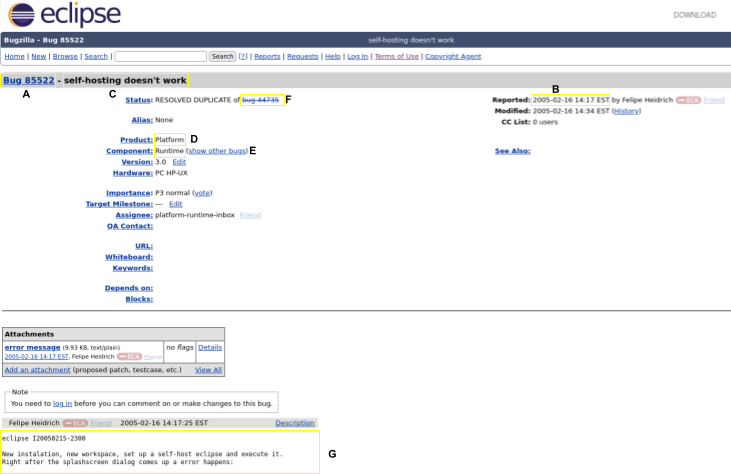

In [36]:
from IPython import display
display.Image("https://irving-muller.github.io/images/bug-report-eclipse.png")

- A : identifiant du bug report
- B : date de création
- C : résumé
- D : produit
- E : composant
- F : l'identifiant du rapport dont le bug report est dupliqué
- G : description


Le script suivant charge le jeu de données de test et définit certaines variables globales:

--------


- A : bug report id
- B : creation date
- C : summary
- D : product
- E : component
- F : the report id which the bug report is duplicate
- G : description

The following script loads the test dataset and define some global variables:

In [37]:
import os

# définir le chemin du dossier qui contient les données
FOLDER_PATH = "data/"
PAGE_FOLDER = os.path.join(FOLDER_PATH, 'bug_reports_small')


# Charger l'ensemble de données d'évaluation 
import json


training_file = open(os.path.join(FOLDER_PATH, "training.txt"))
validation_file = open(os.path.join(FOLDER_PATH, "validation.txt"))
word_vec_path = os.path.join(FOLDER_PATH, "glove.42B.300d_clear.txt")

def read_dataset(f):
    for line in f:
        line = line.strip()
        
        if len(line) == 0:
            continue
        
        rep1, rep2, label = line.split(',')

        rep1 = int(rep1)
        rep2 = int(rep2)
        label = 1.0 if int(label) > 0 else 0.0 
        
        yield (rep1, rep2, label)
    

training_pairs = list(read_dataset(training_file))
validation_pairs = list(read_dataset(validation_file))

training_reports_set = set()

for r1, r2, _ in training_pairs:
    training_reports_set.add(r1)
    training_reports_set.add(r2)

# 4 - Web scraping

"Le *web scraping* (parfois appelé harvesting) est une technique d'extraction du contenu de sites Web, via un script ou un programme, dans le but de le transformer pour permettre son utilisation dans un autre contexte, par exemple le référencement." [Wikipedia](https://fr.wikipedia.org/wiki/Web_scraping)


-----

Web scraping consists in extracting relevant data from pages and prepare it for computational analysis.


## 4.1 - Question 1 (4 points)

**Implémentez la fonction ```extract_data_from_page``` qui extrait les informations suivantes du code HTML: l'ID du bug report, la date de création, le titre, le produit, le composant, l'ID du bug report dont il est un duplicata, et la description.**

La fonction ```extract_data_from_page``` retourne un dictionnaire avec la structure suivante:

```python
 {"report_id": int, 
  "dup_id": int or None (the report id which it is duplicate), 
  "component": string, 
  "product": string, 
  "summary": str, 
  "description": string, 
  "creation_date": string} 
```

Par exemple, pour le bug report "bug_report/18431.html", la fonction *extract_data_from_page* retourne:
 
```python
{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT'}
```
**Remarques:**

- La date de création doit être représentée sous la forme d'un "année-mois-jour heure:minute fuseau horaire". Si un bug report n'est pas un duplicata, alors dup_id doit être None.
- Indice: [lxml parse](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#installing-a-parser) est plus rapide que html.parser*

---------

Implement ```extract_data_from_page function```. This function extracts the following information from the html: bug report id, creation date, title, product, component, the report id which it is duplicate and description.

*extract_data_from_page* function returns a dictionary with the following structure:


 ```python
{"report_id": int, 
  "dup_id": int or None (the report id which it is duplicate), 
  "component": string, 
  "product": string, 
  "summary": str, 
  "description": string, 
  "creation_date": int}
 ```
For instance, when extract_data_from_page receives "bug_report/18431.html", it returns:
 
```python
{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT'}
```

**Notes:**

- Creation date have to be represented as "year-mont-day hour:minute timezone". If bug report is not duplicate, dup_id have to be None.
- HINT: [lxml parse](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#installing-a-parser) is faster than html.parser

In [38]:
# Installing beautifulsoup4, if not already installed.
!conda install --yes --prefix {sys.prefix} beautifulsoup4

# Installing lxml parsing library to use instead of the built in parser (html.parser)
!conda install --yes --prefix {sys.prefix} lxml

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [39]:
import os
import re
import dateutil.parser as dparser
from bs4 import BeautifulSoup

"""
    Scrap le contenu du rapport de html 
    
    :param pagepath: le chemin du fichier html. 
    :return: 
        {
        "report_id": int,
        "dup_id": int or None (l'identifiant du rapport dont il est dupliqué), 
        "component": string, 
        "product": string, 
        "summary": string, 
        "description": string, 
        "creation_date": string
        }
"""
def extract_data_from_page(pagepath):
    file = open(pagepath, "r")
    page_content = file.read()
    file.close()
        
    content = {}
    parsed_html = BeautifulSoup(page_content, "lxml")

    content['report_id'] = int(os.path.basename(pagepath).replace('.html', ''))

    # Dup ID
    parsed_anchors = parsed_html.find(id="static_bug_status").select("span > a")
    if parsed_anchors == []:
        content['dup_id'] = None
    else:
        extracted_id = re.findall(r'\d+', parsed_anchors[0].get_text(strip=True))
        content['dup_id'] = int("".join(extracted_id))

    content['component'] = re.findall(r'^\w+', parsed_html.find("td", {"id":"field_container_component"}).get_text(strip=True))[0]

    content['product'] = parsed_html.find("td", {"id":"field_container_product"}).get_text(strip=True)

    content['summary'] = parsed_html.find(id="short_desc_nonedit_display").get_text(strip=True)

    content['description'] = parsed_html.find(id="c0").select('pre')[0].get_text(strip=True)

    parsed_creation_date = parsed_html.find(id="bz_show_bug_column_2").select("td")[0].get_text(strip=False)
    content['creation_date']= re.findall(r'^\d+\-\d+\-\d+\ \d+\:\d+\ EDT', parsed_creation_date)[0]

    return content



## 4.3 - Extraction de texte à partir de HTML / Text extraction from HTML


In [40]:
import os
from multiprocessing import Pool, TimeoutError
from time import time
import json
import tqdm

# Indexer chaque rapport par son identifiant 
index_path = os.path.join(FOLDER_PATH, 'bug_reports.json')

if os.path.isfile(index_path):
    report_index = json.load(open(index_path))
else:
    # Extraire le contenu d'une page Web 

    # Cela peut être lent (environ 15 minutes). Testez votre code avec un petit échantillon. l'analyse lxml est plus rapide que html.parser
    files = [os.path.join(PAGE_FOLDER, filename) for filename in os.listdir(PAGE_FOLDER)]
    reports = [extract_data_from_page(f) for f in tqdm.tqdm(files)]
    report_index = dict(((report['report_id'], report) for report in reports ))

    # Save preprocessed bug reports
    json.dump(report_index, open(index_path,'w'))
    

# 5 - Prétraitement des données / Data preprocessing

Le prétraitement des données est une tache cruciale en fouille de données. Cette étape nettoie et transforme les données brutes dans un format qui permet leur analyse, et leur utilisation avec des algorithmes de *machine learning*. En traitement des langages (natural language processing, NLP), la *tokenization* et le *stemming* sont des étapes cruciales. De plus, vous implémenterez une étape supplémentaire pour filtrer les mots sans importance.


---

Preprocessing is a crucial task in data mining. This task clean and transform the raw data in a format that can better suit data analysis and machine learning techniques. In natural language processing (NLP), *tokenization* and *stemming* are two well known preprocessing steps. Besides these two steps, we will implement an additional step that is designed exclusively for the twitter domain.





## 5.1 - Tokenization

Cette étape permet de séparer un texte en séquence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple, la phrase "It's the student's notebook." peut être séparé en liste de tokens de cette manière: ["it", " 's", "the", "student", " 's", "notebook", "."].

--- 

In this preprocessing step, a *tokenizer* is responsible for breaking a text in a sequence of tokens (words, symbols, and punctuations). For instance, the sentence "It's the student's notebook." can be split into the following list of tokens: ['It', "'s", 'the', 'student', "'s", 'notebook', '.'].



### 5.1.1 - Question 2 (1 point) 

**Implement** ```tokenize_space_punk``` **qui remplace la ponctuation par un espace, puis tokenise les jetons séparés par des espaces (espace, tabulation, nouvelle ligne). Tous les tokenizers doivent mettre les jetons en minuscule.**


----

**Implement** ```tokenize_space_punk``` **that replaces the punctuation to space and then tokenizes the tokens that are separated by whitespace (space, tab, newline). You have to lowercase the tokens.**

In [41]:
import string
from nltk import RegexpTokenizer

"""
This tokenizer replaces punctuation to spaces and then tokenizes the tokens that are separated by whitespace (space, tab, newline).
"""
def tokenize_space_punk(text: str):
    # return ("".join(word.strip(string.punctuation) for word in text)).split()
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)


tokenize_space_punk("""Hello, this is a test sentence! ...
I am sure that this tokenizer works great!""")


['Hello',
 'this',
 'is',
 'a',
 'test',
 'sentence',
 'I',
 'am',
 'sure',
 'that',
 'this',
 'tokenizer',
 'works',
 'great']

## 5.2 - Stop words removal

### 5.2.1 - Question 3 (0.5 point)

Certains tokens sont sans importance pour la comparaison, car ils apparaissent dans la majorité des discussions. Les supprimer réduit la dimension du vecteur et accélère les calculs.

**Expliquez quels tokens sont sans importances pour la comparaison des discussions. Implémentez la fonction** ```filter_tokens``` **qui retire ces mots de la liste des tokens.**

*Vous pouvez utiliser un ensemble de mots prédéfini.* 

---

There are a set of tokens, call stop words, that are not signficant to the similarity comparison since they appear in most of bug report pages. Thus, removing them decreases the vector dimensionality and turns the similarity calculation computationally cheaper. 

**Describe the tokens that can be removed without affecting the similarity comparison. Moreover, implement the function** ```filter_tokens``` **that removes these words from a list of tokens.**

*You can use a predefined set of words from a library.*

### 5.2.1 Answer

An example set of stop words is "a", "the", "of", "is", "are" and other more commonly used words in the english language (or any other language respectively). These words can be filtered out and the sentences extracted will still remain senseful, such that we can extract their meanings.

There is a fairly popular list of predefined stop words available as a gist on GitHub, used by a lot of other developers when working on NLP projects that can be found [here](https://gist.github.com/sebleier/554280). Furthermore, the NLTK library also has a module that allows developers to quickly obtain a list of stopwords. This module is used in the implementation of the filter_tokens method right below.

In [42]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def filter_tokens(tokens: list[str]):
    result = []
    for token in tokens:
        if token.lower() not in stopwords:
            result.append(token)
    return result

filter_tokens("Example sentence used to showcase the filtering of stopwords".split())

['Example', 'sentence', 'used', 'showcase', 'filtering', 'stopwords']

## 5.3 - Stemming

La racinisation (stemming) est un procédé de transformation des flexions en leur radical ou racine. Par example, en anglais, la racinisation de "fishing", "fished" and "fish" donne "fish" (stem). 


---

The process to convert tokens with the same stem (word reduction that keeps word prefixes) to a standard form is called *stemming*. For instance, the word "fishing", "fished" , "fish" and "fisher" are reduced to the stem "fish".


In [43]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

word1 = ['I', 'tried', 'different', 'fishes']

print([ stemmer.stem(w) for w in word1])

word2 = ['I', 'will', 'tries', 'only', 'one', 'fishing']
print([ stemmer.stem(w) for w in word2])

['i', 'tri', 'differ', 'fish']
['i', 'will', 'tri', 'onli', 'one', 'fish']


### 5.3.1 - Question 4 (0.5 point) 


**Expliquez comment et pourquoi le stemming est utile à notre système.**

---

**Explain how stemming can benift our system.**

Stemming is an important part of the preprocessing of texts in NLP. It facilitates data management in big data systems by reducing costs in size while preventing much loss of information. This process can also be used to reduce redundancy and eliminate a lot of duplicates in a text corpus. 

Stemming, however, can produce unwanted results, because of the stemmer not being aware of the actual root word. For example, the word "went" should root to the word "go", however, this is not the case in a lot of stemming algorithms.

Unfortunately, this process is very language dependant and thus cannot be used all the time. All in all, it is a useful and well thought of process, but must be performed carefully depending on the data that we are dealt, in order to maximize efficiency and prevent data loss.

# 6 - Représentation des données / Data Representation


# 6.1 - Bag of Words (BoW)

De nombreux algorithmes demandent des entrées qui sont toutes de la même taille. Cela n'est pas toujours le cas, notamment pour des données textuelles qui peuvent avoir un nombre variable de mots. 

Par exemple, considérons la phrase 1, ”Board games are much better than video games” et la phrase 2, ”Monopoly is an awesome game!” La table ci-dessous montre un exemple d'un moyen de représentation de ces deux phrases en utilisant une représentation fixe : 

|            | an | are | ! | monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |


Chaque colonne représente un mot du vocabulaire (de longueur 13), tandis que chaque ligne contient l'occurrence des mots dans une phrase. Ainsi, la valeur 2 à la position (1,7) est due au mot *"games"* qui apparaît deux fois dans la phrase 1. 

Ainsi, chaque ligne étant de longueur 13, on peut les utiliser comme vecteur pour représenter les phrases 1 et 2. Ainsi, c'est cette méthode que l'on appelle *Bag-of-Words* : c'est une représentation de documents par des vecteurs dont la dimension est égale à la taille du vocabulaire, et qui est construite en comptant le nombre d'occurrences de chaque mot. Ainsi, chaque token est ici associé à une dimension.

*Pour plus de simplicité, nous considérons le token et le mot comme interchangeables.**

---

Many algorithms only accept inputs that have the same size. However, there are some data types whose sizes are not fixed, for instance, a text can have an unlimited number of words. Imagine that we retrieve two sentences: ”Board games are much better than video games” and ”Monopoly is an awesome game!”. These sentences are respectively named as Sentence 1 and 2. Table below depicts how we could represent both sentences using a fixed representation.

|            | an | are | ! | monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |

Each column of this table 2.1 represents one of 13 vocabulary words, whereas the rows contains the word
frequencies in each sentence. For instance, the cell in row 1 and column 7 has the value 2
because the word games occurs twice in Sentence 1. Since the rows have always 13 values, we
could use those vectors to represent the Sentences 1 and 2. The table above illustrates a technique called bag-of-words. Bag-of-words represents a document as a vector whose dimensions are equal to the number of times that vocabulary words appeared in the document. Thus, each token will be related to a dimension, i.e., an integer.

*For simplicity, we consider token and word as interchangeable.*



## 6.2 - TF-IDF


L'utilisation de la fréquence brute d'apparition des mots, comme c'est le cas avec bag-of-words, peut être problématique. En effet, peu de tokens auront une fréquence très élevée dans un document, et de ce fait, le poids de ces mots sera beaucoup plus grand que les autres, ce qui aura tendance à biaiser l'ensemble des poids. De plus, les mots qui apparaissent dans la plupart des documents n'aident pas à les discriminer. Par exemple, le mot "*de*" apparaît dans beaucoup de documents de la base de données, et pour autant, avoir ce mot en commun ne permet pas de conclure que des documents sont similaires. À l’inverse, le mot "*génial*" est plus rare, mais les documents qui contiennent ce mot sont plus susceptibles d'être positifs. TF-IDF est donc une méthode qui permet de pallier à ce problème.

TF-IDF pondère le vecteur en utilisant une fréquence de document inverse (IDF) et une fréquence de termes (TF).

TF est l'information locale sur l'importance qu'a un mot dans un document donné, tandis que IDF mesure la capacité de discrimination des mots dans un jeu de données. 

L'IDF d'un mot se calcule de la façon suivante:
\begin{equation}
	\operatorname{IDF}(t) = \ln\left( \frac{N+1}{\operatorname{df}(t)+1} \right) + 1,
\end{equation}
où $t$ est un token, $N$ est le nombre de documents dans l'ensemble de données, et $\operatorname{df}(\cdot)$  est le nombre de documents qui contiennent un mot $i$.

Le nouveau poids d'un mot $t$ dans un texte peut ensuite être calculé de la façon suivante:

\begin{equation}
	w(t) = \operatorname{tf}(t) \times \operatorname{IDF}(t),
\end{equation}
où $\operatorname{tf}(\cdot)$ est le terme fréquence du mot 𝑖 dans le document 𝑗, c'est-à-dire le nombre de fois qu'un mot apparaît dans le document. *Nous appelons représentation TF-IDF lorsque les poids de la représentation BoW sont calculés au moyen de TF-IDF.*


----

Using raw frequency in the bag-of-words can be problematic. The word frequency distribution
is skewed - only a few words have high frequencies in a document. Consequently, the
weight of these words will be much bigger than the other ones which can give them more
impact on some tasks, like similarity comparison. Besides that, a set of words (including
those with high frequency) appears in most of the documents and, therefore, they do not
help to discriminate documents. For instance, the word *of* appears in a significant
part of reports. Thus, having the word *of* does not make
reports more or less similar. However, the word *terrible* is rarer and reports that
have this word are more likely to be negative. TF-IDF is a technique
that overcomes the word frequency disadvantages.


TF-IDF weights the vector using inverse document frequency (IDF) and word frequency, called term frequency (TF).
TF is the local information about how important is a word to a specific document.  IDF measures the discrimination level of the words in a dataset.  Common words in a domain are not helpful to discriminate documents since most of them contain these terms. So, to reduce their relevance in the documents, these words should have low weights in the vectors . 
The following equation calculates the word IDF:
\begin{equation}
	\operatorname{IDF}(t) = \ln\left( \frac{N+1}{\operatorname{df}(t)+1} \right) + 1,
\end{equation}
where $t$ is a token, $N$ is the number of documents in the dataset, and $\operatorname{df}(\cdot)$ is the number of documents that contain a word $i$.
The new weight of a word $t$ in a text is defined as:
\begin{equation}
	w(t) = \operatorname{tf}(t) \times \operatorname{IDF}(t),
\end{equation}
where $\operatorname{tf}(\cdot)$ is the term frequency of word $i$ , i.e, number of times that a word appears in the document. *We call TF-IDF representation when the weights of the BoW represention are computed by means of TF-IDF.*


### 6.2.1 - Question 5 (3.5 points)

**Maintenant, vous devez implémenter TF-IDF. La méthode** ```fit``` **calcule IDF sur la base des données textuelles dans X et la méthode** ```transform```  **transforme un texte en une représentation TF-IDF.**

*Remarques*:

- Attention à ce que ```transform``` puisse recevoir des tokens qui n'étaient pas dans X. Dans ce cas, considérez que $\operatorname{df}(\cdot)=0$.
- Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.
- Dans ce TP, nous représentons chaque texte comme une liste de tuples dans laquelle le tuple est composé du roken et de son poids calculé par TF-IDF. Pour améliorer l'efficacité, nous trions les tuples par token. Ainsi, par exemple, la phrase 1 du tableau précédent est représentée comme suit : ```[ ("are", 1.4054), ("better", 1.4054), ("board", 1.4054), ("games", 2.8108), ("much", 1.4054), ("than", 1.4054), ("video", 1.4054)]```.


---

**Now, you have to implement TF-IDF. Method** ```fit``` **computes IDF based on the textual data in X and method** ```transform```  **transforms a text to a TF-IDF representation.**

*Notes*:

- Be careful that ```transform```can receive tokens that were not in X. In this case, consider that $\operatorname{df}(\cdot)=0$.
- For this question, except numpy, you cannot use any external python library (e.g., scikit-learn).
- In this TP, we represent each text as list of tuples in which the tuple are composed of the token and its weight computed by TF-IDF. To improve efficiency, we sort the tuples by the tokens. Thus, for instance, Sentence 1 of previous table is represented as: ```[ ("are", 1.4054), ("better", 1.4054), ("board", 1.4054), ("games", 2.8108), ("much", 1.4054), ("than", 1.4054), ("video", 1.4054)]```.

In [81]:
import math
from itertools import chain

class TFIDF:
    """
    Apprendre les valeurs IDF basées sur les données textuelles dans X

    X:  liste des listes de tokens. Par example, X=[['video','awesome', 'The'], ['house', 'The']] 

    Computes the IDF Based on the following formula: IDF(t) = ln((N + 1)/(df(t) + 1))
    Where: 
        - t is a given word
        - N is the amount of documents in the text corpus
        - df(t) is the amount of documents that contain the word t
    
    Also provides us with tf: the term frequency
        The term frequency is the amount of times that the word comes up in its list of tokens.

        DF: How many times the word comes up in all of the combined documents
        TF: How many times the words comes up in the original document.
    :return: None
    """

    def fit(self, corpus: list[list[str]]):
        # First we make sure the entirety of the words are lowercased
        corpus = list(map(lambda vector: [word.lower() for word in vector], corpus))

        # We can then flatten the corpus to extract the list of unique words. 
        flattened_corpus = list(chain.from_iterable(corpus))
        self.words = set(flattened_corpus)

        # The flattened corpus is also used to count the DF for each word:
        dfs = { word: 0 for word in flattened_corpus }
        for word in flattened_corpus:
            for l in corpus:
                if word in l:
                    dfs[word] += 1

        # We can finally compute the IDF for each word in the unique set of words:
        self.idfs = { word: 1 + math.log((len(corpus) + 1)/(dfs[word] + 1)) for word in self.words }
    """ 
    
    Transforme un texte en une représentation TF-IDF
    
    tokens: liste de tokens.Par example, tokens=['video','awesome', 'The', 'The']
    
    :return: list of lists of tuples. Renvoie la représentation TF-IDF des textes.  
            Par example, [('video', 1.4054), ('awesome', 1.4054), ('The', 2.0)]
    """
    def transform(self, tokens):
        tokens = [token.lower() for token in tokens]

        # The term frequency is computed by counting the number of occurences of each word inside each document in the corpus:
        tfs_list = { token: tokens.count(token) for token in tokens }

        tfidfs = []

        for word, idf in self.idfs.items():
            if word in tfs_list:
                tfidfs.append((word, idf * tfs_list[word]))

        return tfidfs


[('awesome', 1.4054651081081644), ('video', 1.4054651081081644), ('the', 2.0)]

## 6.3 - Word embedding

Récemment, un nouveau type de représentation, appelé word embedding ou word vector, s'est révélé très utile pour la PNL. Dans les plongements de mots, les mots sont représentés comme des vecteurs réels, de faible dimension et denses. Ces vecteurs décrivent les positions des mots dans un nouvel espace de caractéristiques qui conservent les informations syntaxiques et sémantiques. Contrairement à d'autres représentations, word embeddings  souffrent moins de la malédiction de la dimensionnalité et améliorent la capacité du modèle à gérer les mots inconnus et rares dans la formation. Par ailleurs,
en utilisant word embedding, il est possible d'effectuer des opérations arithmétiques et
calculer la distance entre les mots. 

---

Recently, a new type of representation, called word embeddings, word vectors, or distributed word representation, has been shown very useful for NLP. In word embeddings, words are represented as real, low dimensional and dense vectors. Those vectors describe word positions in a new feature space that retain syntactic and semantic information. In contrast to other representations, word embeddings suffer less with the curse of dimensionality and improve
the model capability to handle unknown and rare words in the training. Furthermore,
using distributed word representations, it is possible to perform arithmetical operations and
calculate the distance between words. 
 

### 6.3.1 - Question 6 (3 points)

Dans ce TP, nous utiliserons des incorporations de mots pour générer une représentation dense du texte, appelée *text embedding*.
Dans ce contexte, le texte peut contenir une phrase ou plusieurs paragraphes.
Le text embedding est calculé comme la moyenne des vecteurs des mots :
\begin{equation}
	e_s = \frac{1}{|s|} \sum_{t \in s} w_t,
\end{equation}
où $|s|$ est la longueur du texte $s$, $w_t$ est word embedding du token $t$ dans $s$ et $e_s$ est text embedding de $s$.

Vous utiliserez les vector des mots pré-entraînées de *glove.42B.300d_clear.txt* dans le dossier *dataset*.
Dans chaque ligne de ce fichier texte, il y a les tokens et leurs valeurs vectorielles. Les valeurs et les tokens sont séparés par des espaces. Dans ce fichier, la longueur de word embedding est de 300.


**Maintenant, vous devez implémenter la méthode** ```generate_embedding``` **qui génère text embedding. L'attribut token2vec est un dictionnaire qui relie un mot à son vecteur.**


*Remarques:*

- Ne pas tenir compte des mots qui n'existent pas dans glove.42B.300d_clear.txt
- Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.


---

In this TP, we will use word embeddings to generate a dense representation of text, called text embedding.
In this context, text could contain a sentence or multiple paragraphs.
The text embedding is computed as average of the vectors of the words:
\begin{equation}
	e_s = \frac{1}{|s|} \sum_{t \in s} w_t,
\end{equation}
where $|s|$ is the length of text $s$, $w_t$ is the word embedding of token $t$ in $s$, and $e_s$ is the embedding of $s$.

You will use the pre-trained word embeddings from *glove.42B.300d_clear.txt* in the folder *dataset*.
In each line of this text file, there are the tokens and theirs vector values. Values and tokens are separated by spaces. In this file, the word embedding length is 300.

****Now, you have to implement the method** ```generate_embedding``` **that generates the text embedding. The attribute token2vec is a dictionary that links a word to its vector.****

*Notes:*
- Disconsider words that does not exist in glove.42B.300d_clear.txt
- For this question, except for numpy, you cannot use any external python library (e.g., scikit-learn).


In [45]:
import math

class TextEmbedding:
    
    def __init__(self):
        with open(word_vec_path, 'r', encoding="utf8") as word_vec_file:
            lines = word_vec_file.readlines()
        
        self.token2vec = dict()
        for line in lines:
            inputs = line.split()
            self.token2vec.update({ inputs[0]: list(map(float, inputs[1:])) })

    """
    Générez text embedding en tant que moyenne de word embeddings dans tokens. 
    Ne pas tenir compte des mots qui n'existent pas dans glove.42B.300d_clear.txt
    tokens: liste de tokens.Par example, ["are", "better", "board", "much"]
    :return:  text embedding (numpy ou liste de nombres réels)
    """
    def generate_embedding(self, tokens: list[str]):
        WORD_EMBEDDING_LENGTH = 300
        embeddings = [0 for i in range(WORD_EMBEDDING_LENGTH)]

        s = len(tokens)
        
        for token in tokens:
            if token not in self.token2vec:
                s -= 1

        if s == 0:
            return embeddings

        for index, _ in enumerate(embeddings):
            for token in tokens:
                if token in self.token2vec:
                    embeddings[index] += self.token2vec[token][index]

            embeddings[index] /= s

        return embeddings

# 7 - Pipeline

La *pipeline* est la séquence d'étapes de prétraitement des données qui transforme les données brutes dans un format qui permet leur analyse.


---

The pipeline is a sequence of preprocessing steps that transform the raw data to a format that is suitable for your problem. 



## 7.1 - Question 7 (2 points) 

**Maintenant, vous devez implémenter le pipeline en suivant les instructions dans les cellules ci-dessous.**

---

**Now, you have to implement the pipeline following the instructions in the cells below.**


In [46]:
"""

Après l'exécution du pipeline, chaque rapport dans report_index doit contenir quatre clés :
     - summary_tfidf : représentation TF-IDF du résumé
     - desc_tfidf : représentation TF-IDF de la description
     - summary_vec : le text embedding du résumé
     - desc_vec : le text embedding  de la description

Par exemple, le rapport 18431 dans report_index (report_index[18431]) est : 

{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT',
 'summary_vec': array([x.xxxxx, x.xxxxx, ... ]),
 'desc_vec':  array([x.xxxxx, x.xxxxx, ... ]),
 'summary_tfidf': [['flowlayout', x], ['ignor', x], ['polylin', x]],
 'desc_tfidf': [['2', x], ['45', x], ['5', x], ['add', x], ['addpoint', x], ... ]}

"""

"""
Étape 1. Tokeniser et supprimer les mots vides dans le résumé et la description de chaque rapport.
"""
#TODO: mettre en œuvre l'étape 1 

############################################################################################

"""
After the pipeline execution, each report in report_index should contain four keys:
    - summary_tfidf: TF-IDF representation of the summary
    - desc_tfidf: TF-IDF representation of the descripton
    - summary_vec: the text embedding of the summary
    - desc_vec: the text embedding of the description

For example, report 18431 in report_index (report_index[18431]) is:

{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT',
 'summary_vec': array([x.xxxxx, x.xxxxx, ... ]),
 'desc_vec':  array([x.xxxxx, x.xxxxx, ... ]),
 'summary_tfidf': [['flowlayout', x], ['ignor', x], ['polylin', x]],
 'desc_tfidf': [['2', x], ['45', x], ['5', x], ['add', x], ['addpoint', x], ... ]}
"""

"""
Step 1. Tokenize and remove the stop words in the summary and description of each report.
"""
#TODO: implement step 1
report_index = json.load(open(index_path))

for key in report_index:
    report_index[key]['summary'] = filter_tokens(
        tokenize_space_punk(report_index[key]['summary'])
    )

    report_index[key]['description'] = filter_tokens(
        tokenize_space_punk(report_index[key]['description'])
    )

In [96]:

"""
Étape 2 . Générez les text embedding du résumé et de la description pour chaque rapport.
Utilisez les textes prétraités à l'étape 1 pour générer les embeddings.
"""

#TODO: mettre en œuvre l'étape 2 
pass

##################################################################################################################

"""
Step 2. Generate the embedding of the summary and description for each report. 
Use the texts preprocessed by step 1 to generate the embeddings.
"""

#TODO: implement step 2

te = TextEmbedding()

for key in report_index:
    report_index[key]['summary_vec'] = te.generate_embedding(report_index[key]['summary'])
    report_index[key]['description_vec'] = te.generate_embedding(report_index[key]['description'])

print(report_index)

{'25': {'report_id': 25, 'dup_id': 28126, 'component': 'Team', 'product': 'Platform', 'summary': ['cvs', 'ui', 'need', 'vcm', 'pref', 'default', 'repo', 'connect', '1gc3746'], 'description': ['would', 'help', 'notion', 'default', 'repositori', 'connect', 'connect', 'project', 'walk', 'list', 'everytim', 'sure', 'goe', 'pref', 'never', 'creat', 'mayb', 'creat', 'mark', 'one', 'default', 'minimum', 'default', 'repositori', 'type', 'cvs', 'cc', 'would', 'help', 'pulldown', 'repo', 'connect', 'wizard', 'default', 'note'], 'creation_date': '2001-10-10 21:35 EDT', 'summary_vec': [0.348773125, -0.09785787500000001, 0.014644275000000005, 0.110129125, 0.05477249999999999, 0.11935375, -1.9815245, 0.77087125, 0.102492375, 0.03551737499999998, -0.10173499999999999, 0.10588175000000004, 0.17875449999999998, 0.16099825, 0.05652650000000001, -0.169837875, -0.13249, 0.0039512499999999895, 0.029578375000000004, -0.024487499999999985, -0.002820500000000002, -0.07392499999999999, 0.3264575, 0.09805375, 0

In [48]:
"""
Étape 3. Appliquez le stemming aux jetons générés à partir de l'étape 1.
"""
#TODO : mettre en œuvre l'étape 3

##################################################################################################################

"""
Step 3. Apply stemming to the tokens generated from Step 1. 
"""
#TODO: implement step 3

for key in report_index:
    report_index[key]['summary'] = [stemmer.stem(word) for word in report_index[key]['summary']]
    report_index[key]['description'] = [stemmer.stem(word) for word in report_index[key]['description']]

In [89]:
"""
Étape 4. Apprenez l'IDF en utilisant le résumé et la description de tous les rapports dans le ensemble d'entraînement.
Vous devez concaténer le contenu de ces deux champs et un rapport sera considéré comme un document afin de calculer la fréquence des documents.
L'entrée de cette étape doit être la sortie de l'étape 3 (stemmed tokens).
"""
# training_reports_set contient tous les rapports de l'ensemble d'entraînement.
# TODO: mettre en œuvre l'étape 4

##################################################################################################################

"""
Step 4. Learn the IDF using the summary and description of all the repors in the training set.
You should concatenate the content of these two fields and a report will be considered a document in order to computer the document frequency.
The input of this step should be output of Step 3 (stemmed tokens).
"""

# training_reports_set contains all reports in the training set.
corpus = [report_index[str(report)]['summary'] + report_index[str(report)]['description'] for report in training_reports_set if str(report) in report_index]

# TODO: implement step 4
tfidf = TFIDF()
tfidf.fit(corpus)

In [91]:
"""
Étape 5. Générez la représentation TF-IDF du résumé et de la description pour chaque rapport.
L'entrée de cette étape doit être la sortie de l'étape 3 (stemmed tokens).
"""
# A FAIRE : mettre en œuvre l'étape 5
for key in report_index:
    report_index[key]['summary_tfidf'] = tfidf.transform(report_index[key]['summary'])
    report_index[key]['description_tfidf'] = tfidf.transform(report_index[key]['description'])
##################################################################################################################

"""
Step 5. Generate the TF-IDF representation of the summary and description for each report.
The input of this step should be output of Step 3 (stemmed tokens).
"""
# TODO: implement step 5
pass

{'report_id': 25, 'dup_id': 28126, 'component': 'Team', 'product': 'Platform', 'summary': ['cvs', 'ui', 'need', 'vcm', 'pref', 'default', 'repo', 'connect', '1gc3746'], 'description': ['would', 'help', 'notion', 'default', 'repositori', 'connect', 'connect', 'project', 'walk', 'list', 'everytim', 'sure', 'goe', 'pref', 'never', 'creat', 'mayb', 'creat', 'mark', 'one', 'default', 'minimum', 'default', 'repositori', 'type', 'cvs', 'cc', 'would', 'help', 'pulldown', 'repo', 'connect', 'wizard', 'default', 'note'], 'creation_date': '2001-10-10 21:35 EDT', 'summary_vec': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# 8 - Cosine Similarity

En PNL, la similarité cosinus est une fonction de similarité populaire utilisée pour comparer les vecteurs de documents. Cette fonction mesure à quel point la direction de deux vecteurs est différente et ses valeurs sont comprises entre -1 et 1.

La similarité en cosinus est définie comme:
\begin{equation}
    \operatorname{cos(v, v')} = \frac{\sum_{i=1}^{n} v_i  v_i'}{\sqrt{\sum_{i=1}^{n} v_i^2} \sqrt{\sum_{i=1}^{n}v_i'^2}},
\end{equation}
where $v$ and $v'$ sont des vecteurs de $n$ dimensions.


-------------

In NLP, the cosine similarity is a popular similarity function used to compare the vectors
of documents. This function measures how different is the direction of two vectors, and its
values are between -1 and 1. 

Cosine similarity is defined as:
\begin{equation}
    \operatorname{cos(v, v')} = \frac{\sum_{i=1}^{n} v_i  v_i'}{\sqrt{\sum_{i=1}^{n} v_i^2} \sqrt{\sum_{i=1}^{n}v_i'^2}},
\end{equation}
where $v$ and $v'$ are vectors with $n$ dimensions.


## 8.1 - Question 8 (2 points)

**Vous devez implémenter deux fonctions :**

  1. ```cosine_sim_tf_idf``` : calcule la similarité cosinus de deux représentations générées au moyen de TF-IDF.
  2. ```cosine_sim_embedding``` : calcule la similarité de cosinus de deux text embeddings.


*Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy. De plus, si le dénominateur est zéro, alors vous devez considérer que cos(.) = 0*

--------------------

**You have to implement two functions:**

 1. ```cosine_sim_tf_idf```: computes the cosine similarity of two representations generated using TF-IDF.
 2. ```cosine_sim_embedding```: computes the cosine similarity of two field embeddings.


*For this question, except for numpy, you cannot use any external python library (e.g., scikit-learn). Also, if the denominator is zero, so you should consider that cos(.) = 0*




In [103]:
from itertools import chain

def cosine_sim_tf_idf(r1: list[tuple[str, int]], r2: list[tuple[str, int]]) -> float:
    """
    r1: Représentation TF-IDF . 
    r2: Représentation TF-IDF .
    :return la similitude cosinus de r1 et r2
    """

    # Assuming R1 and R2 have the same length? 

    def square_sum(r: dict):
        return math.sqrt(sum(list(map(lambda key: pow(r[key], 2), r))))

    numerator = 0
    denom = 0
    
    r1_dict = dict(r1)
    r2_dict = dict(r2)

    numerator = sum([r1_dict[key]*r2_dict[key] if key in r2_dict else 0 for key in r1_dict])
    denom = square_sum(r1_dict) * square_sum(r2_dict)

    return numerator/denom

cosine_sim_tf_idf(
    [('ui', 2.386294361119891), ('cvs', 1.0), ('connect', 0.7768564486857903), ('pref', 1.9808292530117262), ('default', 1.2876820724517808), ('need', 1.2876820724517808), ('1gc3746', 2.386294361119891), ('vcm', 1.0), ('repo', 1.0)],
    [('everytim', 2.386294361119891), ('help', 3.9616585060234524), ('never', 2.386294361119891), ('repositori', 1.0289843684365985), ('pulldown', 2.386294361119891), ('cvs', 1.0), ('would', 2.5753641449035616), ('connect', 2.330569346057371), ('pref', 1.9808292530117262), ('creat', 2.0), ('list', 2.386294361119891), ('wizard', 1.9808292530117262), ('minimum', 2.386294361119891), ('default', 5.150728289807123), ('walk', 1.9808292530117262), ('notion', 2.386294361119891), ('mayb', 1.9808292530117262), ('sure', 2.386294361119891), ('type', 2.386294361119891), ('cc', 2.386294361119891), ('project', 0.083709268125845), ('mark', 2.386294361119891), ('goe', 2.386294361119891), ('one', 1.2876820724517808), ('repo', 1.0), ('note', 1.0)]
)

0.25538361014868294

In [113]:
def cosine_sim_embedding(vec1, vec2):
    """
    v1: text embedding
    v2: text embedding
   
    :return la similitude cosinus de vec1 and vec2
    """
    def square_sum(v: list):
        return math.sqrt(sum(list(map(lambda x: pow(x, 2), v))))

    numerator = sum([x * y for x, y in zip(vec1, vec2)])
    denom = square_sum(vec1) * square_sum(vec2)
    return numerator/denom

cosine_sim_embedding(
    [0.1451703857142857, 0.13581671428571426, -0.008595199999999999, 0.11706357142857142, 0.1640107142857143, 0.11065571428571429, -2.547592857142857, 0.5369, 0.0642204285714286, 0.11671571428571428, -0.11045428571428571, -0.030916528571428563, 0.27530842857142857, 0.058239428571428574, 0.17004765714285713, 0.028416000000000007, -0.0880092857142857, -0.05182300000000001, 0.12764157142857144, -0.008731999999999995, 0.004524614285714291, -0.02701484285714287, 0.08301085714285715, -0.05327757142857142, 0.07557388571428571, 0.03518657142857142, -0.13336242857142858, 0.022007999999999996, -0.33628671428571427, -0.13012142857142858, -0.45852142857142864, 0.03618885714285715, 0.16557942857142854, -0.07002028571428572, 0.021391571428571423, -0.0011954285714285853, 0.0560257142857143, -0.21261845714285713, 0.17309355714285715, -0.044670571428571414, -0.1118582, -0.09799985714285715, 0.11220542857142855, 0.02974230000000001, -0.027221657142857177, -0.04451900000000001, -0.0406853, -0.17654857142857142, 0.07854714285714286, -0.24758514285714286, -0.17842414285714286, -0.11242342857142858, -0.1150552857142857, -0.0913797142857143, 0.331691, 0.20152157142857144, -0.21867685714285715, 0.06193420000000001, -0.10992198571428571, -0.12045357142857142, -0.20512542857142857, -0.31477242857142856, -0.00924099999999999, 0.14146727142857143, 0.044717557142857134, 0.08972077142857142, -0.21965928571428575, -0.1384939857142857, 0.06840461428571427, -0.23061085714285715, 0.26523178571428574, -0.05068057142857143, -0.23731285714285713, -0.08232742857142858, -0.11790857142857145, 0.10247357142857141, 0.19293428571428572, 0.188993, 0.23615699999999998, -0.3811837142857143, -0.184027, 0.11652014285714286, 0.012895714285714286, -0.011495428571428573, 0.10466514285714286, -0.17864957142857144, 0.1531114285714286, -0.04164857142857144, 0.12530114285714286, 0.22639942857142858, -0.11703714285714285, -0.189147, -0.05699, 0.17957907142857144, -0.06938000000000001, -0.25803214285714277, -1.70942, -0.23840042857142857, -0.028540857142857156, -0.19304457142857143, -0.09652642857142858, 0.114362, 0.12208569999999999, 0.10790471428571428, 0.09430000000000001, 0.084812, 0.02022985714285715, 0.24177442857142858, 0.042883728571428574, -0.06901257142857142, -0.12057657142857144, 0.010266999999999995, 0.027700714285714283, 0.049368428571428556, -0.26409342857142853, 0.21908512857142856, 0.39283571428571423, 0.16345528571428572, 0.19023075714285712, 0.09130357142857141, 0.01868071428571429, -0.03968154285714285, 0.16154571428571426, -0.041547999999999995, -0.075118, 0.16573785714285716, -0.14385628571428571, 0.05343871428571429, -0.031265714285714286, 0.2723317142857143, 0.11042799999999998, 0.2663501428571428, -0.2570087142857143, 0.030720642857142856, 0.0730047142857143, -0.2443902857142857, 0.01023028571428571, -0.053501285714285716, -0.07148014285714287, 0.26505142857142855, 0.18890614285714286, 0.204911, 0.09102951428571428, -0.11314757142857139, -0.11823485714285716, -0.04134142857142858, 0.07325099999999998, -0.17368685714285714, -0.1440999285714286, 0.21086600000000003, -0.04200999999999999, -0.11779242857142858, 0.03292742857142857, -0.10815471428571428, 0.06786914285714286, 0.01547921428571428, -0.020812428571428572, -0.039601, 0.08222485714285714, 0.028252999999999997, -0.1991214285714286, -0.08361, -0.2534795714285714, -0.2407788571428571, -0.030351428571428578, -0.022001428571428585, -0.20394857142857145, -0.07186954285714285, -0.15278985714285717, 0.04368428571428572, -0.3085112857142857, -0.067173, 0.10623071428571428, -0.4823957142857142, 0.13180499999999998, 0.04074885714285714, -0.23018557142857138, 0.012930714285714283, 0.2191558571428571, -0.11072657142857142, 0.20274499999999998, -0.025864285714285718, -0.04133985714285714, -0.1182437142857143, 0.10002657142857142, -0.223817, 0.3863085714285714, 0.25180128571428567, 0.14588857142857142, 0.014538042857142866, 0.08565342857142856, 0.16292285714285715, 0.047570857142857144, -0.029764571428571425, -0.032397857142857145, 0.08800442857142857, 0.0806257142857143, 0.152411, 0.22368842857142862, 0.1407862857142857, 0.06007613857142857, 0.10467, -0.26918314285714284, 0.03572271428571429, 0.12374314285714283, -0.07763785714285713, 0.07950804285714286, 0.009975000000000003, 0.26852714285714285, -0.053162714285714285, 0.24483857142857143, -0.020369285714285708, -0.12956557142857145, -0.11477157142857143, 0.06965085714285713, -0.2843803714285714, -0.029313714285714287, -0.025601142857142854, 0.12072071428571429, 0.00019514285714285405, 0.041946857142857154, -0.2534042857142857, -0.20438142857142855, -0.004659428571428569, -1.5923785714285714, 0.3655092857142857, 0.13644828571428572, -0.12692142857142857, -0.1476502857142857, 0.260617, 0.010285428571428576, -0.05288671428571429, 0.020186500000000003, 0.20198742857142854, 0.18158242857142856, 0.13184199999999996, -0.16308257142857144, 0.2273542857142857, 0.02632300000000001, 0.15326642857142855, 0.14457614285714285, -0.09430428571428573, -0.03326271428571432, -0.13669857142857142, -0.02073285714285714, -0.21612342857142858, 0.057703700000000004, 0.004115142857142873, -0.13430757142857142, -0.09151685714285715, 0.0602182, -0.2080411285714285, -0.098712, 0.06722085714285712, 0.06417114285714286, -0.3957785714285715, -0.07346771428571428, 0.0866622857142857, 0.037041, -0.14547428571428572, 0.11643971428571429, 0.1311733714285714, -0.009584285714285724, -0.06921097142857145, -0.07067007142857143, -0.13491598714285716, -0.1177784285714286, -0.019667142857142845, 0.2398191, -0.156857, -0.14233814285714289, 0.06353665714285715, 0.22677771428571428, 0.07755914285714285, 0.18274357142857142, -0.13323014285714282, 0.29734557142857143, 0.1283705142857143, 0.08282357142857144, 0.03995614285714287, -0.32747299999999996, -0.02751485714285715, -0.06368857142857141, 0.156371, -0.050088, 0.2933985714285714, -0.054780571428571435, -0.03062285714285715, -0.0036195714285714243, 0.04665414285714286, -0.15681557142857142, 0.028163714285714285, -0.09144294285714284, -0.12335885714285715, -0.11135800000000003, -0.35818428571428573, -0.08784157142857144, -0.06302957142857143, 0.04318142857142857, -0.14777328571428572],
    [0.051455759090909076, -0.02520044545454546, -0.03719479090909092, 0.07859181818181818, -0.0036831818181818255, 0.01754953181818181, -2.496314363636363, 0.4810556545454547, 0.0023264090909090873, -0.059488409090909085, 0.00945907727272727, -0.04128116363636364, 0.07094144545454548, 0.0030441363636363587, 0.061403618181818186, -0.06664490909090909, -0.03585236363636364, -0.02662681818181817, -0.013558881181818177, 0.04309389090909093, 0.05107328181818182, 0.011543004545454543, 0.045334363636363624, -0.011529318181818193, 0.03988038181818182, 0.03259886363636365, 0.05516731818181817, 0.02569322727272727, -0.022020013636363647, 0.04849581818181819, -0.35183427272727275, -0.010117409090909107, 0.16876204545454543, -0.07925095454545453, -0.08620095454545457, -0.030147863636363636, 0.00826846818181818, -0.16048704545454545, 0.02797613636363637, -0.04812177272727274, -0.11141200000000002, -0.05846186363636363, -0.03386300454545454, 0.09477468636363634, -0.08749883636363635, -0.02355127272727272, 0.06465066363636363, -0.09221860454545458, -0.04839652727272726, -0.12342240909090911, -0.13496116363636365, -0.034117499999999995, -0.036766777272727265, 0.02695261636363635, 0.11823853636363636, 0.007309463181818175, -0.013717090909090908, 0.00810696818181818, -0.0836584909090909, -0.050623499999999995, -0.09420818181818183, -0.1370123772727273, 0.10416172727272728, -0.016843590909090902, 0.01877822727272727, 0.09113838181818182, -0.11435527272727274, -0.04751136363636363, 0.054168909090909094, -0.08453152909090907, 0.1088238090909091, 0.08586486363636364, -0.014506845454545458, 0.005752999999999995, 0.010126099999999994, -0.14879686363636366, 0.13867886363636364, 0.05602890909090908, 0.10325809545454544, -0.08136382272727273, -0.15385336363636365, -0.24640300159090914, 0.07755005090909094, -0.036052890909090904, 0.06263618636363638, -0.12993786363636364, 0.13445113636363631, 0.10774740909090909, 0.12203190909090908, 0.07544849999999999, 0.06674927272727273, -0.05717036818181818, 0.012102954545454554, -0.027924340909090906, -0.05391478636363636, -0.1955250454545454, -1.492736136363636, -0.05807782727272728, 0.14188122727272726, 0.045881863636363644, -0.08594595454545455, 0.12850888181818182, 0.11339799545454547, 0.03956736363636364, 0.02104824545454546, -0.14682313636363636, 0.09636413636363636, -0.018911045454545448, 0.014248640909090919, -0.05658804545454543, 0.041007409090909094, -0.08998345454545453, 0.002941527272727277, 0.030550954545454537, -0.18037477272727276, 0.17011731363636365, 0.22781049999999994, 0.0590860909090909, 0.07689181818181819, 0.09561922727272724, 0.04902250000000001, -0.03698669945454545, 0.004124954545454539, -0.04952123636363637, 0.002301545454545445, 0.048901736363636365, -0.04132335, 0.03851775, -0.09750932454545454, 0.05813226818181818, 0.013694045454545462, 0.053795909090909096, -0.09648277272727271, -0.0781241681818182, -0.05669454545454545, -0.06577118181818184, -0.05915096818181817, 0.008256195454545466, 0.08905140909090908, 0.2735763636363637, 0.17470949545454548, 0.06351218181818183, 0.1348854090909091, 0.009979490909090906, -0.08774027272727271, -0.10168859090909091, 0.059714681818181826, -0.02366222727272727, 0.08157073181818184, 0.07504221818181817, -0.011958499999999995, -0.044960090909090915, 0.12288217727272731, 0.0029058181818181856, 0.08271154090909093, 0.044035714090909096, -0.10070104545454545, 0.0036515454545454516, 0.047044681818181826, 0.08625454545454546, 0.03561474545454545, -0.07411812727272728, -0.12286689090909092, -0.0774427909090909, -0.0056456090909090826, 0.061604545454545453, -0.11557859999999999, 0.054239545454545436, -0.02134895454545455, -0.034705409090909085, -0.1673518181818182, -0.053117363636363615, 0.0572185909090909, -0.15335013636363637, 0.08026481818181817, 0.019943913636363643, -0.0915138181818182, 0.011774681818181811, -0.024552000000000004, -0.07547249999999998, 0.16222861272727274, 0.04014314545454544, 0.09343681818181816, -0.08637904545454546, -0.06581508181818183, -0.11647313636363639, 0.0877495909090909, -0.04219754545454546, 0.018544, 0.06267721818181816, 0.04057578999999998, 0.11786298999999999, 0.02918569999999999, -0.10443581818181819, 0.03963420909090908, -0.04987959090909091, 0.08271584090909086, 0.06644363636363636, 0.12298594545454546, 0.0329190318181818, 0.08209558954545454, -0.05212727272727273, -0.2015146818181818, 0.06929327272727273, 0.112635, -0.08280986363636365, 0.05508740909090908, 0.052722818181818204, 0.3027214181818182, 0.03414563636363637, 0.18446154545454546, -0.012400049999999996, -0.13061831818181818, 0.005916363636363637, 0.015057909090909089, -0.031432563636363646, -0.0813099409090909, -0.015326803181818187, -0.0038442727272727313, -0.02110768181818182, 0.09908945181818182, -0.08735363636363637, -0.23586511818181818, -0.08704081818181818, -1.7652586363636364, 0.022705818181818185, 0.03486322727272728, -0.05005018181818181, 0.008176181818181817, 0.024090227272727274, -0.1399787727272727, 0.08841918181818183, -0.09582534090909091, 0.11132604545454546, 0.049540363636363625, 0.018872954545454554, 0.0029261818181818204, 0.053500181818181794, -0.13547940909090908, 0.09504427272727273, -0.023161199545454557, 0.06494105454545453, -0.32565140909090906, -0.0335789090909091, 0.016115681818181817, -0.10534252272727275, 0.03889062272727273, 0.023318545454545456, -0.04746763636363636, -0.05089236363636363, 0.009677972727272728, 8.28590909090929e-05, -0.05960368181818181, -0.11705213636363636, 0.11034668181818179, -0.1282153181818182, -0.04648604545454546, 0.04182249999999999, 0.0012804181818181757, -0.04607777272727272, 0.025683636363636363, 0.08273580000000003, -0.008361500000000004, -0.009903045454545454, -0.012968859090909092, -0.12741872318181818, -0.10840725909090908, -0.016077590909090902, 0.12560363636363633, -0.006941363636363632, 0.06900936363636365, -0.04056649090909092, -0.04610438636363636, 0.02289895454545454, 0.07242067727272727, -0.03774651772727272, 0.10383485, 0.07855202727272727, 0.08640304545454545, -0.018725318181818187, 0.1432979090909091, -0.15303445454545458, -0.026900909090909083, 0.07265287727272728, 0.008150890909090906, 0.16320468181818185, 0.002342454545454549, -0.04122231818181818, -0.06555736363636364, -0.009557181818181814, -0.0933600909090909, 0.030517272727272723, -0.03634477727272727, -0.14176804545454544, -0.19669759090909092, 0.02499495454545455, -0.06073590909090909, 0.07393595454545453, 0.055605818181818194, -0.1163460909090909]
)

0.871432777318624

# 9 - Extraction de features / Feature extraction

Nous formons un modèle de régression logistique pour prédire si une paire de rapports est dupliqué ou non. Les features utilisées pour la classification sont énumérées ci-dessous :

1. Similitude en cosinus de la représentation TF-IDF du résumé.
1. Similitude en cosinus de la représentation TF-IDF de la description.
1. Similitude en cosinus de les embedding de résumés.
1. Similitude en cosinus de les embedding de description.
1. Un feature binaire qui est 1.0 lorsque le rapport provient des mêmes composants. Sinon, c'est 0.0.
1. Une feature binaire qui est 1.0 lorsque le rapport provient des mêmes produits. Sinon, c'est 0.0.


-------------

We train a logistic regression model to predict whether a pair of reports is duplicate or not. The features employed for the classifion are listed below:

1. Cosine similarity of the TF-IDF representation of summary.
2. Cosine similarity of the TF-IDF representation of description.
2. Cosine similarity of the summary embeddings.
2. Cosine similarity of the description embeddings.
2. A binary feature that is 1.0 when the report are from the same components. Othewise, it is 0.0.
2. A binary feature that is 1.0 when the report are from the same products. Othewise, it is 0.0.



## 9.1 - Question 9 (1 point)

**Maintenant, implémentez** ```extract_features``` **qui extrait les fonctionnalités ci-dessus à partir d'une paire de rapports.**

*rm_ftr_idx* est un paramètre qui permet de supprimer une ou plusieurs des features. Si *rm_ftr_idxs=[]*, alors toutes les features seront utilisées. Sinon, *rm_ftr_idxs* correspond aux positions des entités dans la liste précédente à supprimer. 


-------------


**Now, implement** ```extract_features```**that extracts the above features from a pair of reports.** 

*rm_ftr_idx* is parameter that allow to remove one or more of the original features. If *rm_ftr_idxs=[]*, so all features will be used. Otherwise, *rm_ftr_idxs* is the positions of the features in the previous list to be removed.



In [20]:
def extract_features(r1, r2, rm_ftr_idxs=[]):
    """
    Extraire les features d'une paire (r1, r2).

    La représentation TF-IDF du résumé et des descriptions est accessible sur r1 et r2 à l'aide des clés 'summary_tfidf' et 'desc_tfidf'.
    Les embeddings du résumé et de la description est accessible sur r1 et r2 à l'aide des clés 'summary_vec' et 'desc_vec'. 
    
    r1: Dictionnaire qui contient toutes les informations sur un rapport
    r2: Dictionnaire qui contient toutes les informations sur un rapport
    rm_ftr_idxs: Supprimer des features.
         Par exemple, ftr_opt=[1,4] supprime la similarité en cosinus de la représentation TF-IDF du résumé et la similarité en cosinus des description embeddings.
    
    :return un vecteur de nombres réels. 
    """
    pass

# 10 - Entraînement/Training

In [21]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Charger des étiquettes à partir de l'ensemble d'apprentissage
y_train = np.asarray([ y for _, _, y in  training_pairs ])

def train_clf(rm_ftr_idxs=[]):
    # Extraire les features 
    X_train = np.asarray([ extract_features(report_index[r1], report_index[r2], rm_ftr_idxs) for r1, r2, _ in  training_pairs ])
    return LogisticRegression(random_state=0).fit(X_train, y_train)

# 11 - Question 10  (2.5 points)

Maintenant, il est temps d'évaluer le classificateur. En plus de cela, vous devrez effectuer une ablation study pour mesurer l'efficacité de chaque fonctionnalité. La ablation study consiste à retirer un seul composant de l'architecture d'origine, et à mesurer à quel point cette modification isolée impacte les performances du modèle. Plus un composant affecte les performances, plus il est considéré comme efficace.

Pour cette question, vous devez indiquer la précision du classificateur (fonction ```compute_acc```) pour les configurations suivantes :

1. Classificateur avec toutes les features
2. Classificateur sans *similitude en cosinus de la représentation TF-IDF du résumé et de la description*.
4. Classificateur sans *similitude en cosinus des embeddings de résumé et de description*.
5. Classificateur sans *comparaison de composants*.
5. Classificateur sans *comparaison de produits*.
    
*Décrivez également les résultats et les conclusions.*

**Cette note de question sera pénalisée de 1.5 point lorsque la précision du classificateur avec toutes les features (6 features) est inférieure à 0,91.** 

-----

Now, it is time to evaluate the classifier. Besides that, you will have to perform an ablation study to measure the effectiveness of each feature.  Ablation study consist in removing a single component from the original architecture, and measuring how much this isolated modification impacts the model performance. The more a component affects the performance, the more effective it is considered.

For this question, you have to report the classifier accuracy (function ```compute_acc```) for the following configurations:

1. Classifier with all features
2. Classifier without *cosine similarity of the TF-IDF representation of summary and description*.
4. Classifier without *cosine similarity of the summary and description embeddings*.
5. Classifier without *component comparison*.
5. Classifier without *product comparison*.
    
*Also, describe the results and findings.*


**The mark will be penalized by 1.5 point when the accuracy of the classifier with full features (6 features) is lower than 0.91.** 



In [22]:
import numpy as np


def compute_acc(classifier, X):
    # Compute accuracy
    y = np.asarray([ y for _, _, y in  validation_pairs ])
    return classifier.score(X, y)

    
    
